In [1]:
# SET UP (it will take a long time to run)
using Pkg; Pkg.activate("C:/Users/nicot/GitHub/Tutorial_DynMacro")
using Plots; using Optim; using Interpolations; using LinearAlgebra; using Distributions
Pkg.status()

  Activating environment at `C:\Users\nicot\GitHub\Tutorial_DynMacro\Project.toml`


      Status `D:\GitHub\Tutorial_DynMacro\Project.toml`
  [31c24e10] Distributions v0.23.11
  [2774e3e8] NLsolve v4.5.1
  [429524aa] Optim v1.4.1
  [fcd29c91] QuantEcon v0.16.2


Assume there is a shock $Z$ that can have two values and follow a markov chain.

Bellman's equation is
$$
V(K,Z) = \max_{0 \leq K' \leq f(K,Z)}
    \left\{
        u(f(K,Z)-K') + \beta \; \mathbb{E}[ V(K',Z')\,|Z]
    \right\}
$$

With

$$
\mathbb{E}[ V(K',Z')\,|Z]= \pi_{Z_1|Z}V(K',Z_1)+\pi_{Z_2|Z}V(K',Z_2)+\pi_{Z_3|Z}V(K',Z_3)
$$

If the grid had $n$ points in the deterministic model in this version it will have $3\times n$ points.

In [2]:
γ = 2.0
α = 0.27 
𝛿 = 0.01
u(c) = γ==1.0 ?  log(c)  :  c^(1-γ)/(1-γ)   # CRRA

Z=[0.99 1.0 1.01]
Π=[0.61 0.34 0.05; 
   0.24 0.52 0.24;
   0.05 0.34 0.61]

Z_grid = 1:3
f(k,z)=Z[z]*k^α+(1-𝛿)*k # Cobb-Douglas with depretiation

@show K_0 = 23.0 # initial condition
β = 0.984

V_0(k,z) = u(f(k,z)-k)/(1-β)

Zmax=maximum(Z)
Zmin=minimum(Z)
# Kmax = (Zmax/𝛿)^(1/(1-α)) # Demasiado grande
@show Kss_max = ((β*Zmax*α)/(1-β*(1-𝛿)))^(1/(1-α))
@show Kss_min = ((β*Zmin*α)/(1-β*(1-𝛿)))^(1/(1-α))

n=500 # grid points
which_k = 3 # 1: Kss   2: Kg   3: Kmax     # choose one of the above
K_grid = range(min(K_0,Kss_min*0.75), max(K_0,Kss_max*1.25), length=n)

V_0_mat=[V_0(k,z) for k in K_grid, z in Z_grid];

K_grid

K_0 = 23.0 = 23.0
Kss_max = ((β * Zmax * α) / (1 - β * (1 - 𝛿))) ^ (1 / (1 - α)) = 24.67811336083481
Kss_min = ((β * Zmin * α) / (1 - β * (1 - 𝛿))) ^ (1 / (1 - α)) = 24.01115654779594


18.008367410846958:0.02573000859758829:30.847641701043514

In [3]:
# In order to get a vector of the diferent states
# Although, there is a point in interpolate over K there is no point in interpolate over Z since it is already discrete.
# One can do the following:
f_test(x,s) = s*x^2
xs=1:0.5:5 # x is a range
ss=1:3 # z is a range

ys = [f_test(x,s) for x in xs, s in ss] # y is a matrix

f_test_lin(s) = LinearInterpolation(xs, ys[:,s]);
ys

9×3 Matrix{Float64}:
  1.0    2.0   3.0
  2.25   4.5   6.75
  4.0    8.0  12.0
  6.25  12.5  18.75
  9.0   18.0  27.0
 12.25  24.5  36.75
 16.0   32.0  48.0
 20.25  40.5  60.75
 25.0   50.0  75.0

In [4]:
f_test_lin(3)(2.5)

18.75

In [5]:
# In order to get a vector of the diferent states
f_test_linV(k) = [f_test_lin(s)(k) for s in 1:3]

f_test_linV (generic function with 1 method)

In [6]:
@show f_test_linV(2.5)
@show f_test_linV(2.7);

f_test_linV(2.5) = [6.25, 12.5, 18.75]
f_test_linV(2.7) = [7.350000000000001, 14.700000000000003, 22.050000000000004]


In [59]:
@show Π[1,:]
@show f_test_linV(2.7)
@show Π[1,:]'*f_test_linV(2.7)
@show Π[1,1]*f_test_linV(2.7)[1]+Π[1,2]*f_test_linV(2.7)[2]+Π[1,3]*f_test_linV(2.7)[3]


Π[1, :] = [0.61, 0.34, 0.05]
f_test_linV(2.7) = [7.350000000000001, 14.700000000000003, 22.050000000000004]
(Π[1, :])' * f_test_linV(2.7) = 10.584000000000003
Π[1, 1] * (f_test_linV(2.7))[1] + Π[1, 2] * (f_test_linV(2.7))[2] + Π[1, 3] * (f_test_linV(2.7))[3] = 10.584000000000003


10.584000000000003

In [4]:
function T(V, K_grid, Z_grid)
    V_lin(z) = LinearInterpolation(K_grid, V[:,z], extrapolation_bc = Line()) # linear interpolation of the vectorized (or not) function
    V_new=zeros(length(K_grid),length(Z_grid)); g_new=zeros(length(K_grid),length(Z_grid)); K_min=K_grid[1]
    for z in Z_grid
        objectives = (K -> u.((f(k,z)-K)) + β * Π[z,:]' * [V_lin(z)(K) for z in Z_grid]   for k in K_grid)
        results = maximize.(objectives, K_min,f.(K_grid,z)) 
        V_new[:,z] = Optim.maximum.(results)
        g_new[:,z] = Optim.maximizer.(results)
    end
    return [V_new, g_new]
end

T (generic function with 1 method)

In [126]:
# TEST
#Z_grid=1:3
#K_grid=0.5:0.25:1.25
#V_0(k,z) = u(f(k,z)-k)/(1-β)
#V_0_mat=[V_0(k,z) for k in K_grid, z in Z_grid]
#V_new=ones(length(Z_grid)); g_new=ones(length(Z_grid)); K_min=K_grid[1]
#T(V_0_mat, K_grid, Z_grid)

2-element Vector{Matrix{Float64}}:
 [-76.25780088736411 -75.82373674719176 -75.39263701678718; -68.25659016445131 -67.87016059542783 -67.48629077311789; -63.15250004803981 -62.79539573863562 -62.44063389609027; -59.4887143640258 -59.15226877183917 -58.81802202807178]
 [0.5000000122213487 0.5000000123455532 0.5000000124697576; 0.5000000099000769 0.5000000100386508 0.5000000101772246; 0.5000000136990052 0.5000000137915661 0.5000000138841268; 0.5000000091083666 0.5000000092066754 0.5000000093049844]

Number of iterations: 50
Distance between last two value functions: 0.0056546304869056


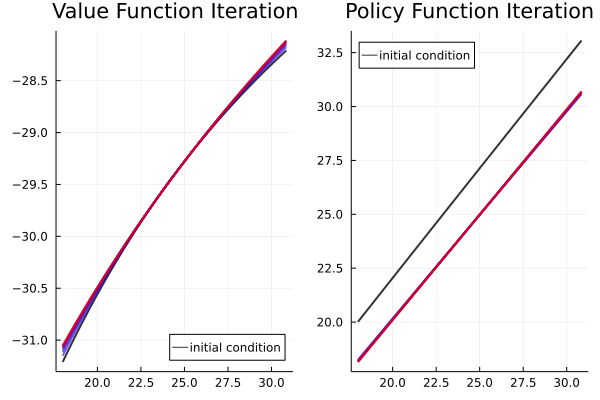

In [5]:
V_mat = V_0_mat
g_mat = [f(x,s) for x in K_grid, s in Z_grid]; # matrix

pltV=plot(K_grid, V_mat[:,2], color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")
pltg=plot(K_grid, g_mat[:,2], color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")

max_iter = 50   
tol = 0.0001 # tolerance, if distance is below that I'm fine
distance=tol+1 # some initial condition for distance

i=1
while i < max_iter && distance > tol
    global V_new, g_new = T(V_mat, K_grid, Z_grid)
    if mod(i,5)==0
        plot!(pltV,K_grid, V_new[:,2], color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
        plot!(pltg,K_grid, g_new[:,2], color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
    end
    distance = norm(V_new - V_mat)
    i += 1
    V_mat = V_new  # copy contents into v.  Also could have used v[:] = v_next
end
g_fun(z)=LinearInterpolation(K_grid, g_new[:,z], extrapolation_bc = Line()) # policy function K_t => K_t+1

println("Number of iterations: ",i,"\nDistance between last two value functions: ",distance)

plot!(pltV, legend = :bottomright, title="Value Function Iteration")
plot!(pltg, legend = :topleft, title="Policy Function Iteration")
plot(pltV, pltg)

In [6]:
function cadena_simu(P; init = 1, sample_size = 1000)
    @assert size(P)[1] == size(P)[2] # es una matriz cuadrada?
    N = size(P)[1]

    dists = [Categorical(P[i, :]) for i in 1:N]  # crea N distribuciones

    X = fill(0, sample_size) # crea un vector
    X[1] = init # primer estado

    for t in 2:sample_size
        dist = dists[X[t-1]] # selecciona la distribucion correspondiente
        X[t] = rand(dist) # saca un valor aleatorio segun la distribución
    end
    return X
end

cadena_simu (generic function with 1 method)

In [7]:
Time=1000
Z_1 = cadena_simu(Π, init = 2, sample_size = Time)
Z_2 = cadena_simu(Π, init = 2, sample_size = Time)
Z_3 = cadena_simu(Π, init = 2, sample_size = Time);



In [8]:
y_path = fill(0.0, Time)
c_path = fill(0.0, Time)
K_path = fill(0.0, Time)
y_path[1] = f(K_0,2)
K_path[1] = g_fun(Z_1[1])(K_0)
c_path[1] = y_path[1] - K_path[1]
for t in 2:(Time)  
    K_path[t] = g_fun(Z_1[t])(K_path[t-1])
    y_path[t] = f(K_path[t-1],Z_1[t])
    c_path[t] = y_path[t] - K_path[t]  
end

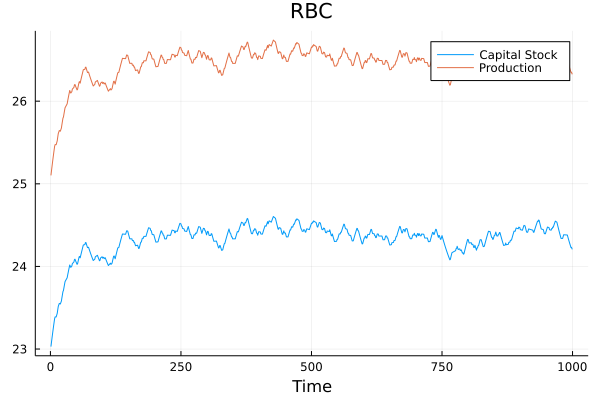

In [9]:
plot(1:Time,K_path,label="Capital Stock",title="RBC",xlabel="Time")
#plot!(1:Time,c_path,label="Consumption")
plot!(1:Time,y_path,label="Production")

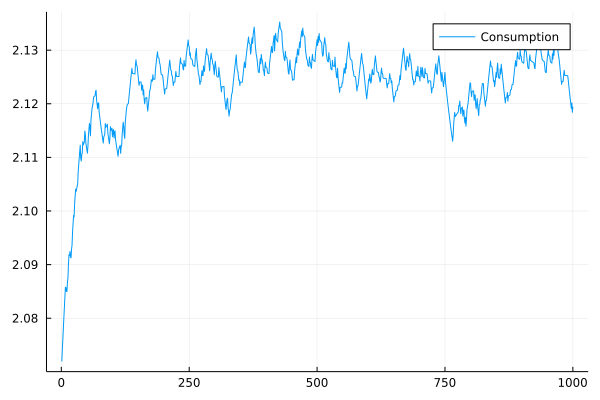

In [10]:
plot(1:Time,c_path,label="Consumption")

